# Quantum Classifier

### Importing Necessary Libraries

In [11]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

import matplotlib.pyplot as plt


# Set a random seed
np.random.seed(42)

### Creating a Dataset of points inside and outside of an Ellipse

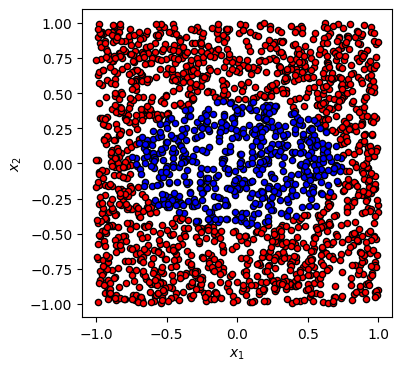

In [12]:
def ellipse(samples, foci1=[0.6,0.0], foci2=[-0.6,0.0], two_a=1.5):
    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 0
        if (np.linalg.norm(x - foci1) + np.linalg.norm(x - foci2)) < two_a:
            y = 1
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals, requires_grad=False), np.array(yvals, requires_grad=False)


def plot_data(x, y, fig=None, ax=None):
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")


Xdata, ydata = ellipse(2000)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(Xdata, ydata, fig=fig, ax=ax)
plt.show()

### Function Creating the Density Matrix Representation of a state

In [13]:
def density_matrix(state):
    # Calculates the density matrix representation of a state.
    return state * np.conj(state).T


label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False)

### Creating a Node inside a Device representing the Universal Classifier

In [14]:
dev = qml.device("lightning.qubit", wires=1)

@qml.qnode(dev)
def qcircuit(params, x, y):
    # A variational quantum circuit representing the Universal classifier.
    for p in params:
        qml.Rot(*x, wires=0)
        qml.Rot(*p, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))

## Functions

### Cost

In [15]:
def cost(params, x, y, state_labels=None):
    # Cost function to be minimized.
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

### Test

In [16]:
def test(params, x, y, state_labels=None):
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)

### To Calculate the Accuracy

In [17]:
def accuracy_score(y_true, y_pred):
    score = y_true == y_pred
    return score.sum() / len(y_true)

### To Create Minibatches to Iterate through

In [18]:
def iterate_minibatches(inputs, targets, batch_size):
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

## Model

### Generate training and test data

In [19]:
num_training = 200
num_test = 2000

Xdata, y_train = ellipse(num_training)
X_train = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1), requires_grad=False)))

Xtest, y_test = ellipse(num_test)
X_test = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1), requires_grad=False)))

### Training through Adam optimizer and evaluating the classifier

In [20]:
num_layers = 7
learning_rate = 0.6
epochs = 21
batch_size = 16

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = np.random.uniform(size=(num_layers, 3), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  0 | Cost: 0.270725 | Train accuracy: 0.570000 | Test Accuracy: 0.585500
Epoch:  1 | Loss: 0.186792 | Train accuracy: 0.715000 | Test accuracy: 0.714000
Epoch:  2 | Loss: 0.184490 | Train accuracy: 0.735000 | Test accuracy: 0.720500
Epoch:  3 | Loss: 0.072566 | Train accuracy: 0.975000 | Test accuracy: 0.968000
Epoch:  4 | Loss: 0.090000 | Train accuracy: 0.875000 | Test accuracy: 0.867000
Epoch:  5 | Loss: 0.105310 | Train accuracy: 0.850000 | Test accuracy: 0.821500
Epoch:  6 | Loss: 0.156921 | Train accuracy: 0.800000 | Test accuracy: 0.790500
Epoch:  7 | Loss: 0.090438 | Train accuracy: 0.900000 | Test accuracy: 0.893000
Epoch:  8 | Loss: 0.168911 | Train accuracy: 0.770000 | Test accuracy: 0.725000
Epoch:  9 | Loss: 0.197305 | Train accuracy: 0.610000 | Test accuracy: 0.598500
Epoch: 10 | Loss: 0.173680 | Train accuracy: 0.770000 | Test accuracy: 0.757500
Epoch: 11 | Loss: 0.135505 | Train accuracy: 0.795000 | Test accuracy: 0.808000
Epoch: 12 | Loss: 0.189839 | Train accur

## Result

Cost: 0.069545 | Train accuracy 0.935000 | Test Accuracy : 0.915500
Learned weights
Layer 0: [ 2.88892261 -4.49638936  5.07629162]
Layer 1: [11.03050187 -0.31264003  1.67456769]
Layer 2: [6.3020045  0.69050221 5.25952183]
Layer 3: [ 2.46278348  1.305161   -3.34384962]
Layer 4: [-5.2762519   7.09652714 -4.94919787]
Layer 5: [-9.0775609  10.10925726  3.97738669]
Layer 6: [1.60025306 2.93238601 0.47317265]


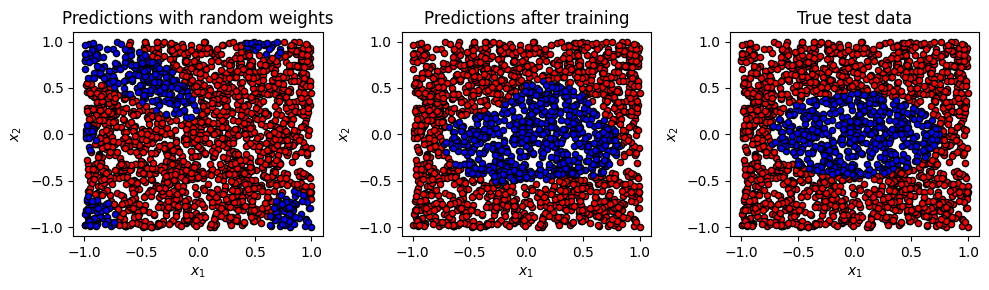

In [21]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))


fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_test, initial_predictions, fig, axes[0])
plot_data(X_test, predicted_test, fig, axes[1])
plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()